# Realistic Ocean Simulations in pure Julia

In this tutorial we will build a global ocean simulation using the ClimaOcean and Oceananigans Julia packages.
The simulation will be at a nominal one-degree with parameterizations for mesoscale eddies.
We will set up the grid, download and interpolate the bathymetry, 
download forcing files, and finally set up and run the simulation

### ***Bonus***
At the end of the tutorial we will change the resolution to allow the spontaneous generation of eddies and 
remove the eddy parameterization to see some beautiful ocean turbulence develop! (make sure to have GPU access
for this step!)


## Required software

The tutorial is quite computationally expensive, therefore, if you have 
access, it is recommended to run the tutorial on one GPU, otherwise:
- bla bla bla
- bla bla bla

## Packages:

Let's start by importing the necessary packages, these are:
- ClimaOcean: the ocean model
- Oceananigans: the fluid dynamics library doing the heavy lifting
- OrthogonalSphericalShellGrids: contains the constructor for the Tripolar grid we will use in the tutorial
- Printf: always useful for spitting out output
- CairoMakie: visualization package to visualize the results

In [23]:
using Suppressor # We use suppressor to suppress all the pesky warnings

@suppress begin
    using ClimaOcean
    using Oceananigans
    using Oceananigans.Units
    using OrthogonalSphericalShellGrids
    using Printf
    using CairoMakie
end

# Building a Global Ocean domain

- problems with poles -> tripolar grid has a fold
- steps to build a grid
(1) architecture
(2) vertical coordinate
(2) grid
(3) bathymetry

### Architectures

using an architecture is easy...
it is possible to choose between:
<br>
(1) CPU 
<br>
(2) GPU 
<br>
(3) Distributed 

In this case, we select `CPU()`, which is always the right choice to start prototyping. 
Building the script on CPUs is better in terms of stacks and to catch potential bugs in the script. 
Once we know that everything works correctly, we can just change this line, and voilá, the simulation runs on GPUs or
multiple CPUs - GPUs!

In [24]:
arch = CPU();

### Vertical coordinates

Vertical coordinates are very important, bla, bla bla...
you can build your own or use one of the provided defaults.

In [25]:
depth = 6000meters
Nz    = 50
h     = 12

z_faces = ClimaOcean.exponential_z_faces(; Nz, h, depth)

# Let's check the maximum and minimum of the spacings
Δz = z_faces[2:end] .- z_faces[1:end-1]

50-element Vector{Float64}:
 487.28835961198456
 448.3269335748955
 412.4806911634705
 379.50055604739555
 349.15736694012685
 321.2402852799469
 295.5553302257458
 271.92403078812094
 250.1821857301038
 230.17872262073888
 211.77464811372147
 194.84208215712033
 179.26336942340686
   ⋮
  20.53620437137951
  18.89422012957408
  17.3835216989915
  15.993612045744797
  14.714833432435753
  13.538300311713364
  12.455837585366297
  11.459923799946267
  10.543638884218211
   9.70061606529353
   8.924997629336778
   8.211394219451238

## Building a grid

talk about the tripolar grid....
<br>
talk about 


coarse_grid = 40×20×1 OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 4×4×4 halo and with precomputed metrics
├── centered at (λ, φ) = (70.0, 1.8005)
├── longitude: Periodic  extent 359.566 degrees                        variably spaced with min(Δλ)=0.638322, max(Δλ)=9.47958
├── latitude:  Oceananigans.Grids.RightConnected  extent 178.5 degrees variably spaced with min(Δφ)=0.99393, max(Δφ)=8.94737
└── z:         Bounded  z ∈ [0.0, 1.0]                                 regularly spaced with Δz=1.0


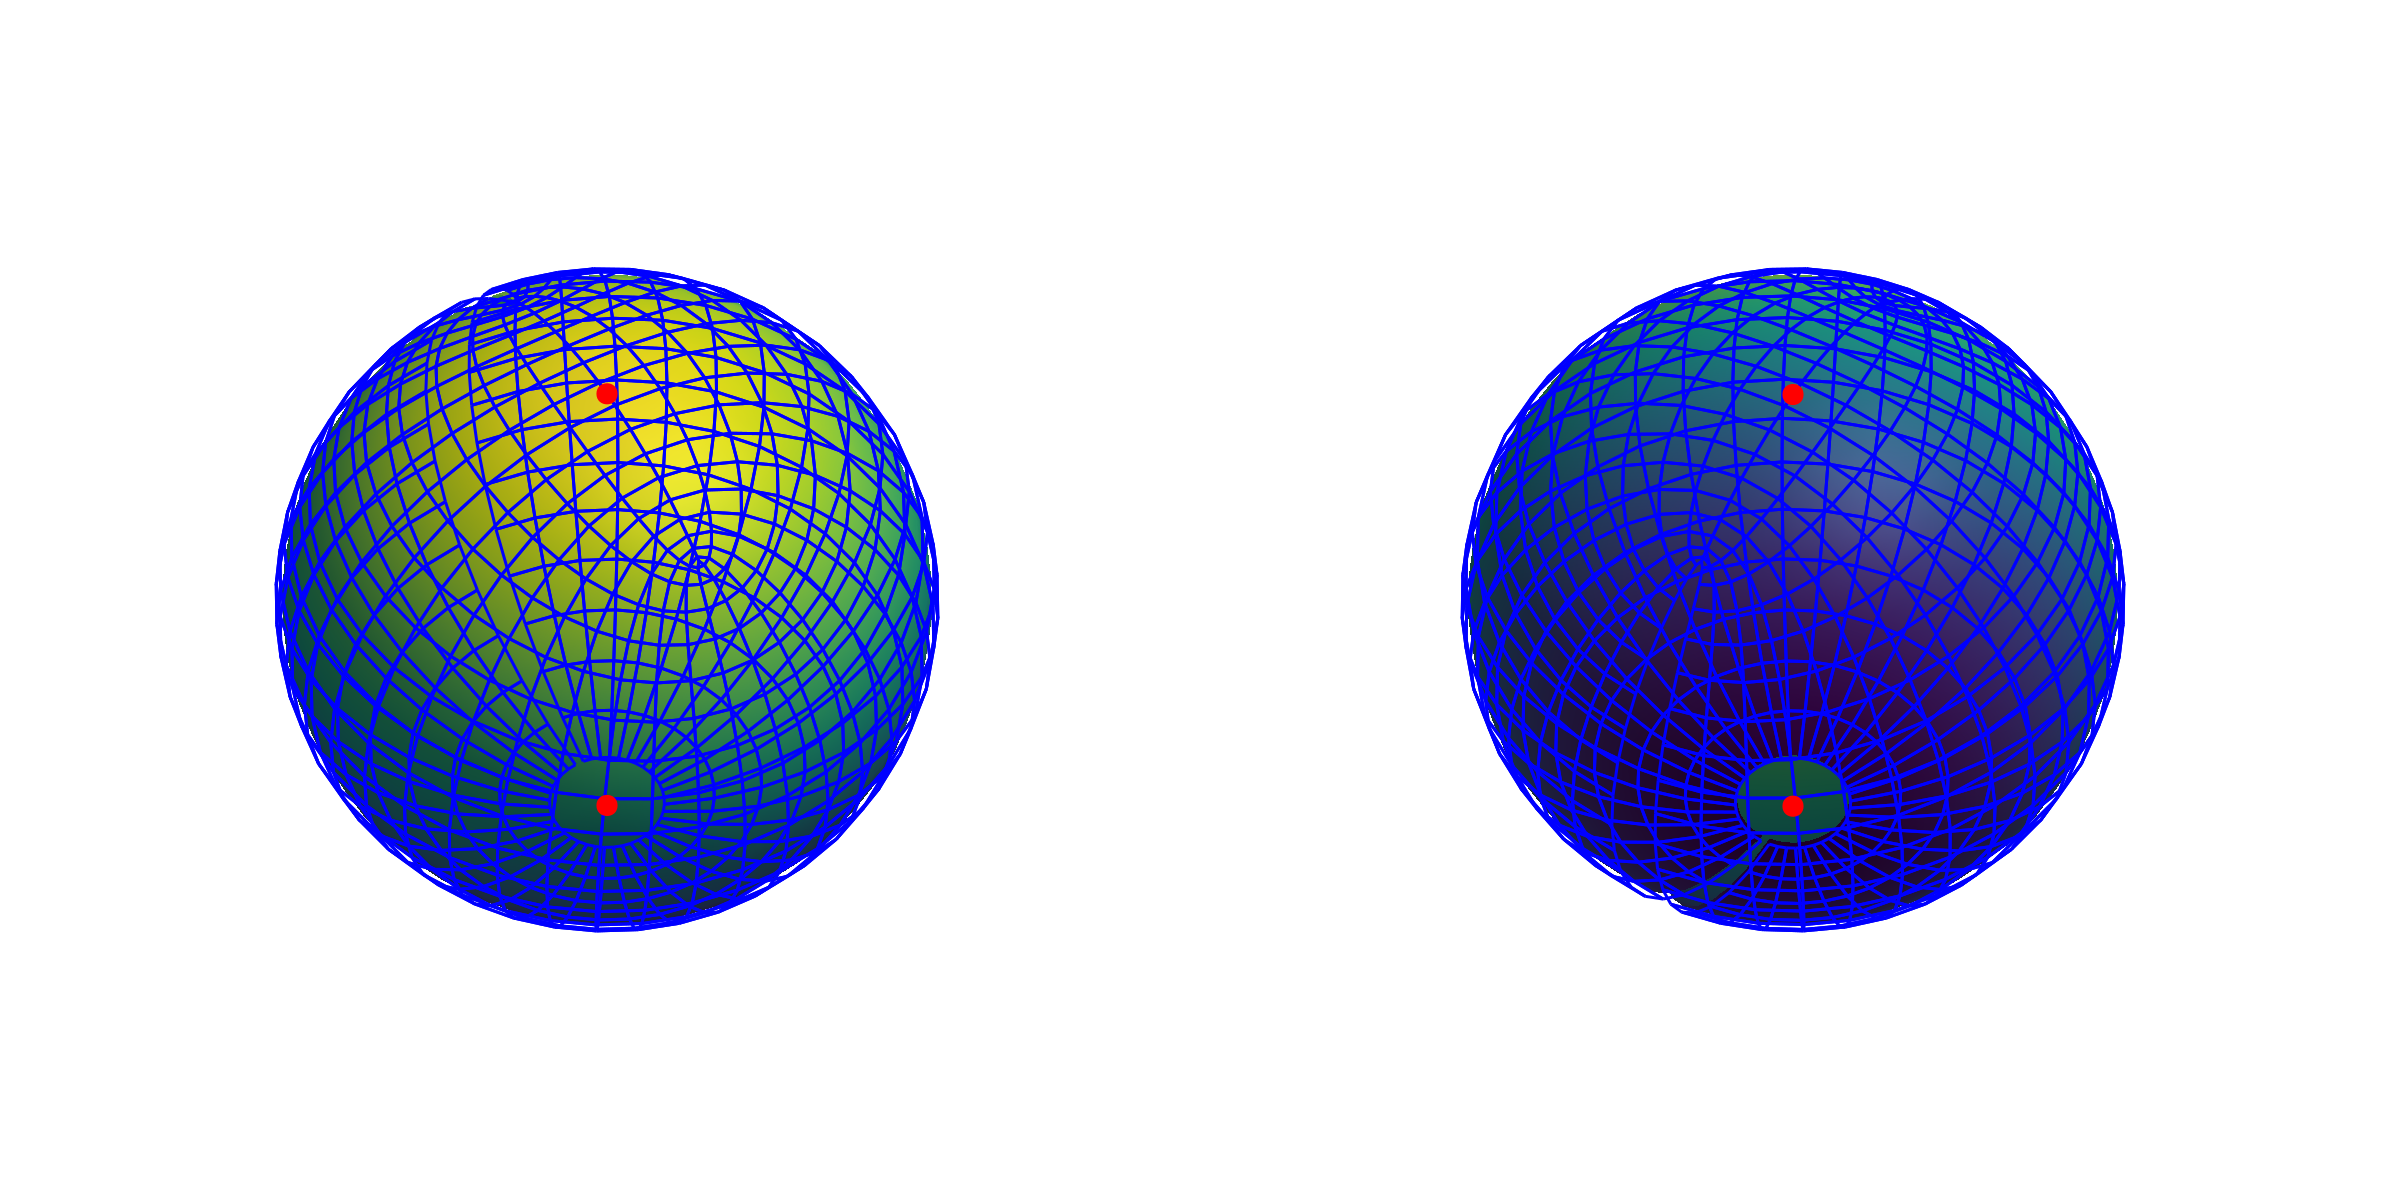

In [39]:
Nx = 40 # longitudinal direction -> 40 points is about 9ᵒ resolution
Ny = 20 # meridional direction -> same thing, 20 points is about 9ᵒ resolution

coarse_grid = TripolarGrid(arch; size = (Nx, Ny, 1))

@show coarse_grid # Note that the minimum horizontal spacings are much lower than 4ᵒ!!!!

# Let's visualize the grid

using OrthogonalSphericalShellGrids: get_cartesian_nodes_and_vertices

cartesian_nodes, _ = get_cartesian_nodes_and_vertices(coarse_grid, Face(), Face(), Center())
xF, yF, zF = cartesian_nodes

cartesian_nodes, _ = get_cartesian_nodes_and_vertices(coarse_grid, Center(), Center(), Center())
xC, yC, zC = cartesian_nodes

## Visualization

fig = Figure(size=(1200, 600))
axN = Axis3(fig[1, 1]; aspect=(1, 1, 1), elevation = +0.9, azimuth = 7, height=1500)
axS = Axis3(fig[1, 2]; aspect=(1, 1, 1), elevation = -0.9, azimuth = 7, height=1500)

for ax in (axN, axS)
    scale_factor = 0.98
    surface!(ax, xC .* scale_factor, yC .* scale_factor, zC .* scale_factor)
    wireframe!(ax, xC, yC, zC, color = :blue)    
    scatter!(ax, 0, 0, +1, color=:red, markersize=15)
    scatter!(ax, 0, 0, -1, color=:red, markersize=15)
    hidedecorations!(ax)
    hidespines!(ax)
end

display(fig);

In [40]:
# Let's build a real one! 
Nx = 360 # longitudinal direction -> 360 points is about 1ᵒ resolution
Ny = 180 # meridional direction -> same thing, 180 points is about 1ᵒ resolution

# Let's wrap our z_faces around a `ZStarVerticalCoordinate` 
# to have a free-surface following vertical coordinate
underlying_grid = TripolarGrid(arch; 
                               size = (Nx, Ny, Nz), 
                               z = ZStarVerticalCoordinate(z_faces), 
                               halo = (7, 7, 4))

# Let's say we want to run the model on a lat-lon grid from -75 to 75 North
# underlying_grid = LatitudeLongitudeGrid(arch; 
#                                         size = (Nx, Ny, Nz), 
#                                         latitude = (-75, 75), 
#                                         longitude = (0, 360),
#                                         z = ZStarVerticalCoordinate(z_faces), 
#                                         halo = (7, 7, 4))

360×180×50 OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 7×7×4 halo and with precomputed metrics
├── centered at (λ, φ) = (70.0, 1.8005)
├── longitude: Periodic  extent 360.162 degrees                          variably spaced with min(Δλ)=0.00753834, max(Δλ)=1.05373
├── latitude:  Oceananigans.Grids.RightConnected  extent 170.944 degrees variably spaced with min(Δφ)=0.0113516, max(Δφ)=0.949721
└── z:         Bounded  z ∈ [-6000.0, 0.0]                               variably spaced with min(Δz)=8.21139, max(Δz)=487.288

## Adding a bathymetry to the grid

ClimaOcean provides a nifty utility to regrid the bathymetry over the grid, the `regrid_bathymetry` function

In [41]:
bottom_height = regrid_bathymetry(underlying_grid; 
                                  minimum_depth=15, 
                                  interpolation_passes=10, 
                                  major_basins=2)

360×180×1 Field{Center, Center, Nothing} reduced over dims = (3,) on OrthogonalSphericalShellGrid on CPU
├── grid: 360×180×50 OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 7×7×4 halo and with precomputed metrics
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: ZeroFlux, north: Zipper, bottom: Nothing, top: Nothing, immersed: Default
└── data: 374×194×1 OffsetArray(::Array{Float64, 3}, -6:367, -6:187, 1:1) with eltype Float64 with indices -6:367×-6:187×1:1
    └── max=0.0, min=-9057.31, mean=-2269.51

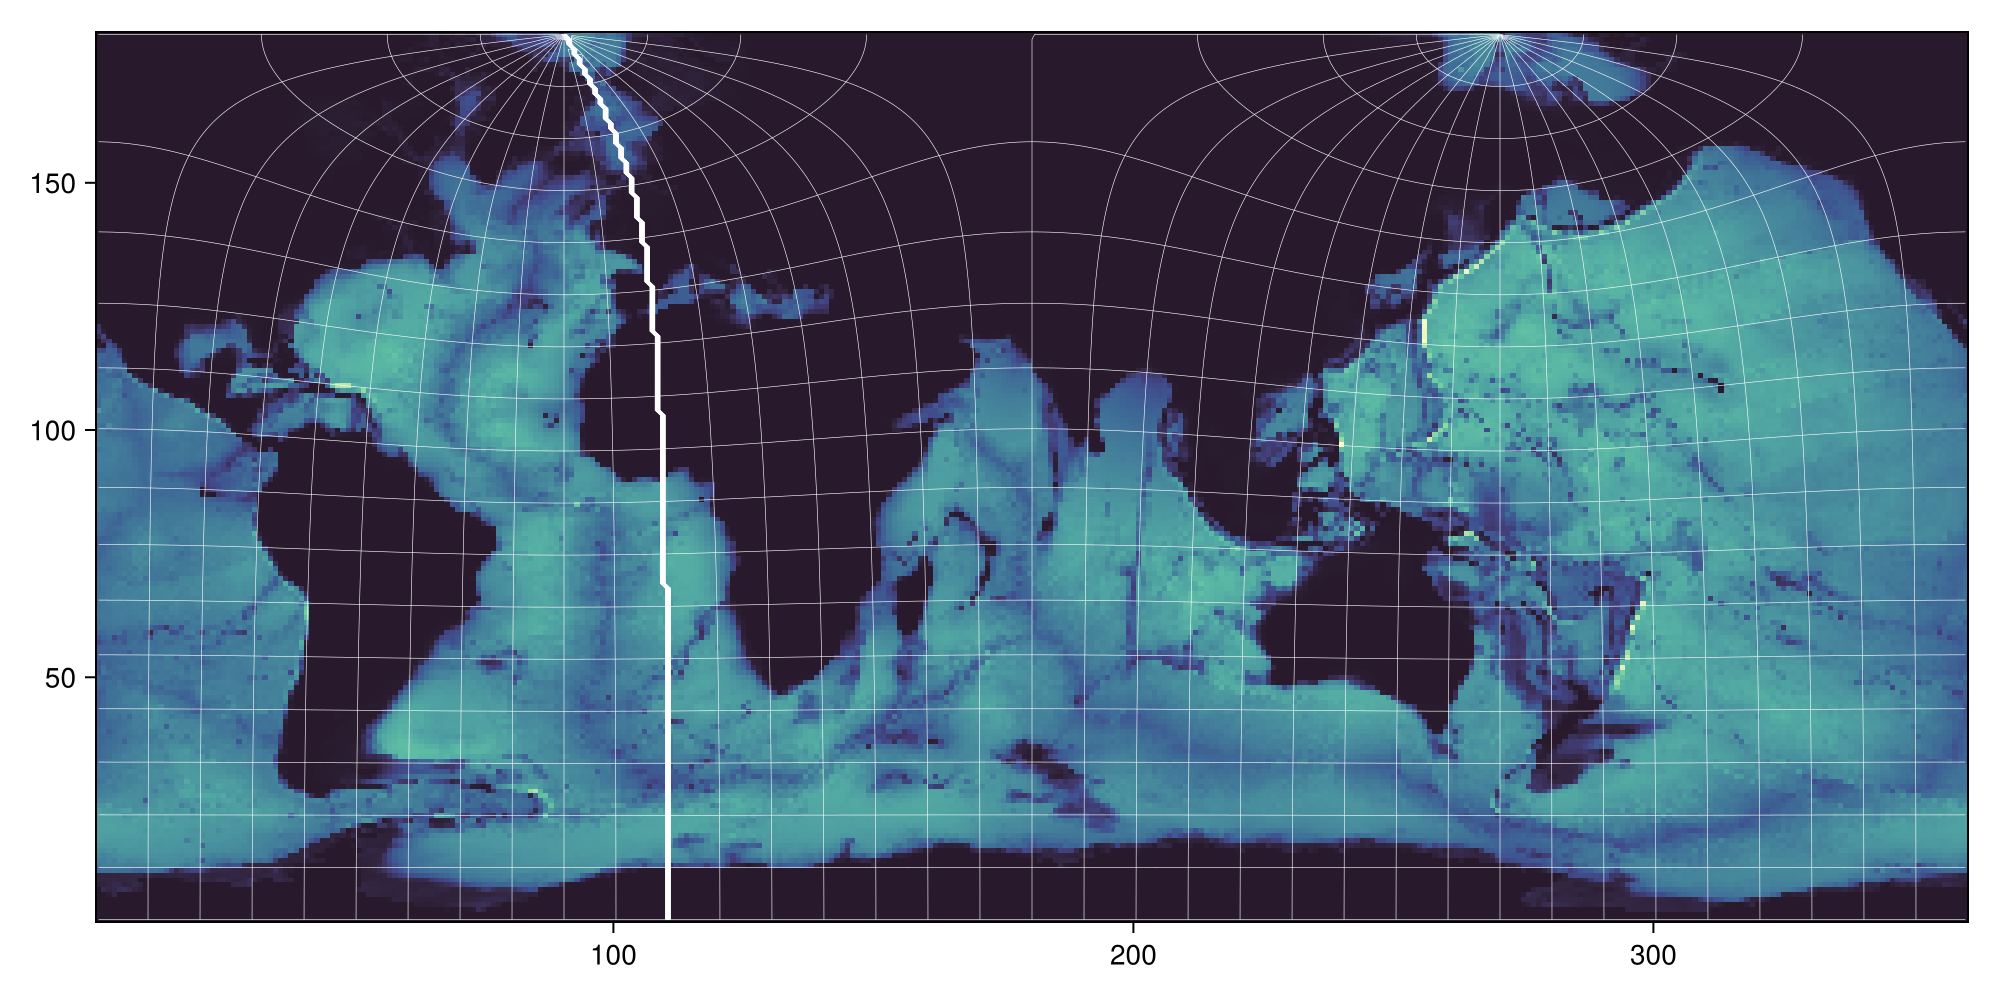

In [42]:
# Let's visualize the bathymetry
fig = Figure(size = (1000, 500))
ax  = Axis(fig[1, 1])
λ, φ, z = nodes(bottom_height)
heatmap!(ax, interior(bottom_height, :, : ,1), colormap=:deep)
contour!(ax, φ, levels=-80:10:90, color=:white, linewidth=0.3)
contour!(ax, λ, levels=0:10:360,  color=:white, linewidth=0.3)
display(fig);

In [43]:
grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bottom_height); active_cells_map=true)

360×180×50 ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 7×7×4 halo:
├── immersed_boundary: GridFittedBottom(mean(z)=-2267.22, min(z)=-6000.0, max(z)=0.0)
├── underlying_grid: 360×180×50 OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 7×7×4 halo and with precomputed metrics
├── centered at (λ, φ) = (70.0, 1.8005)
├── longitude: Periodic  extent 360.162 degrees                          variably spaced with min(Δλ)=0.00753834, max(Δλ)=1.05373
├── latitude:  Oceananigans.Grids.RightConnected  extent 170.944 degrees variably spaced with min(Δφ)=0.0113516, max(Δφ)=0.949721
└── z:         Bounded  z ∈ [-6000.0, 0.0]                               variably spaced with min(Δz)=8.21139, max(Δz)=487.288

Oceananigans stores a map of "active cells" to avoid performing computions in "immersed cells".
<br>
This very simple "trick" is one of the secrets of the performance of Oceananigans


In [44]:
active_cells = map(Tuple{Int, Int, Int}, grid.interior_active_cells)

1664095-element Vector{Tuple{Int64, Int64, Int64}}:
 (87, 22, 1)
 (270, 23, 1)
 (88, 24, 1)
 (269, 24, 1)
 (86, 26, 1)
 (87, 26, 1)
 (84, 27, 1)
 (85, 27, 1)
 (59, 34, 1)
 (60, 34, 1)
 (61, 34, 1)
 (62, 34, 1)
 (63, 34, 1)
 ⋮
 (283, 180, 50)
 (284, 180, 50)
 (285, 180, 50)
 (286, 180, 50)
 (287, 180, 50)
 (290, 180, 50)
 (291, 180, 50)
 (292, 180, 50)
 (293, 180, 50)
 (295, 180, 50)
 (296, 180, 50)
 (297, 180, 50)

In [45]:
length(active_cells) / (Nx * Ny * Nz)

0.5136095679012346

# Configuring an Ocean model

Simple, just do:

In [46]:
@suppress ocean = ocean_simulation(grid)

Simulation of HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 5 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: Inf days
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

#### wait, is it really _that_ simple? 
Yes... and no.
<br>
The above command builds an ocean simulation with default numerics, parameterization, time-step, stop time, tracers, and so on and so forth...
<br>
While a default is nice to have, sometimes (most of the times) it is better to customize the simulation to achieve the desired result

# Configuring an Ocean model (for real)

Several ingredients enter an ocean simulation, the main 3 are
- **Numerics**
- **Parameterizations**
- **Forcing**

and we will try to go in depth in all of these, showing some cases for each.
let's start with the Numerics

# Detour 1: Numerics

Oceananigans is a staggered C-grid, with a z vertical coordinate, this cannot be changed...
<br>
The hydrostatic model solves the primitive equations, this, also cannot be changed...
<br>
however, how to express these equations on the staggered C-grid is left to the user, there are many many options! 
Some good, some a bit less...
<br>
In particular, let's look at 3 different aspects:
<br>
(1) ***Advection***
<br>
(2) ***Free surface***
<br>
(3) ***Time-stepper***

## Chapter 1: the power of good numerics (one-dimensional advection)

numerical discretizations are the basement of an ocean model. Without a good basement, it is difficult to build a sturdy building. 
The same is true in ocean modeling.
<br>
The discretization has an order one effect on the solution. If the discretization is bad, we lose all the benefits of a physically sound and performant parameterization.
<br>
Good numerics make the difference between a good and a bad ocean model.


Let's try to advect a tracer profile to the right with a constant velocity. If the model is not capable of doing that, we might have a couple of problems when it comes to ocean modeling

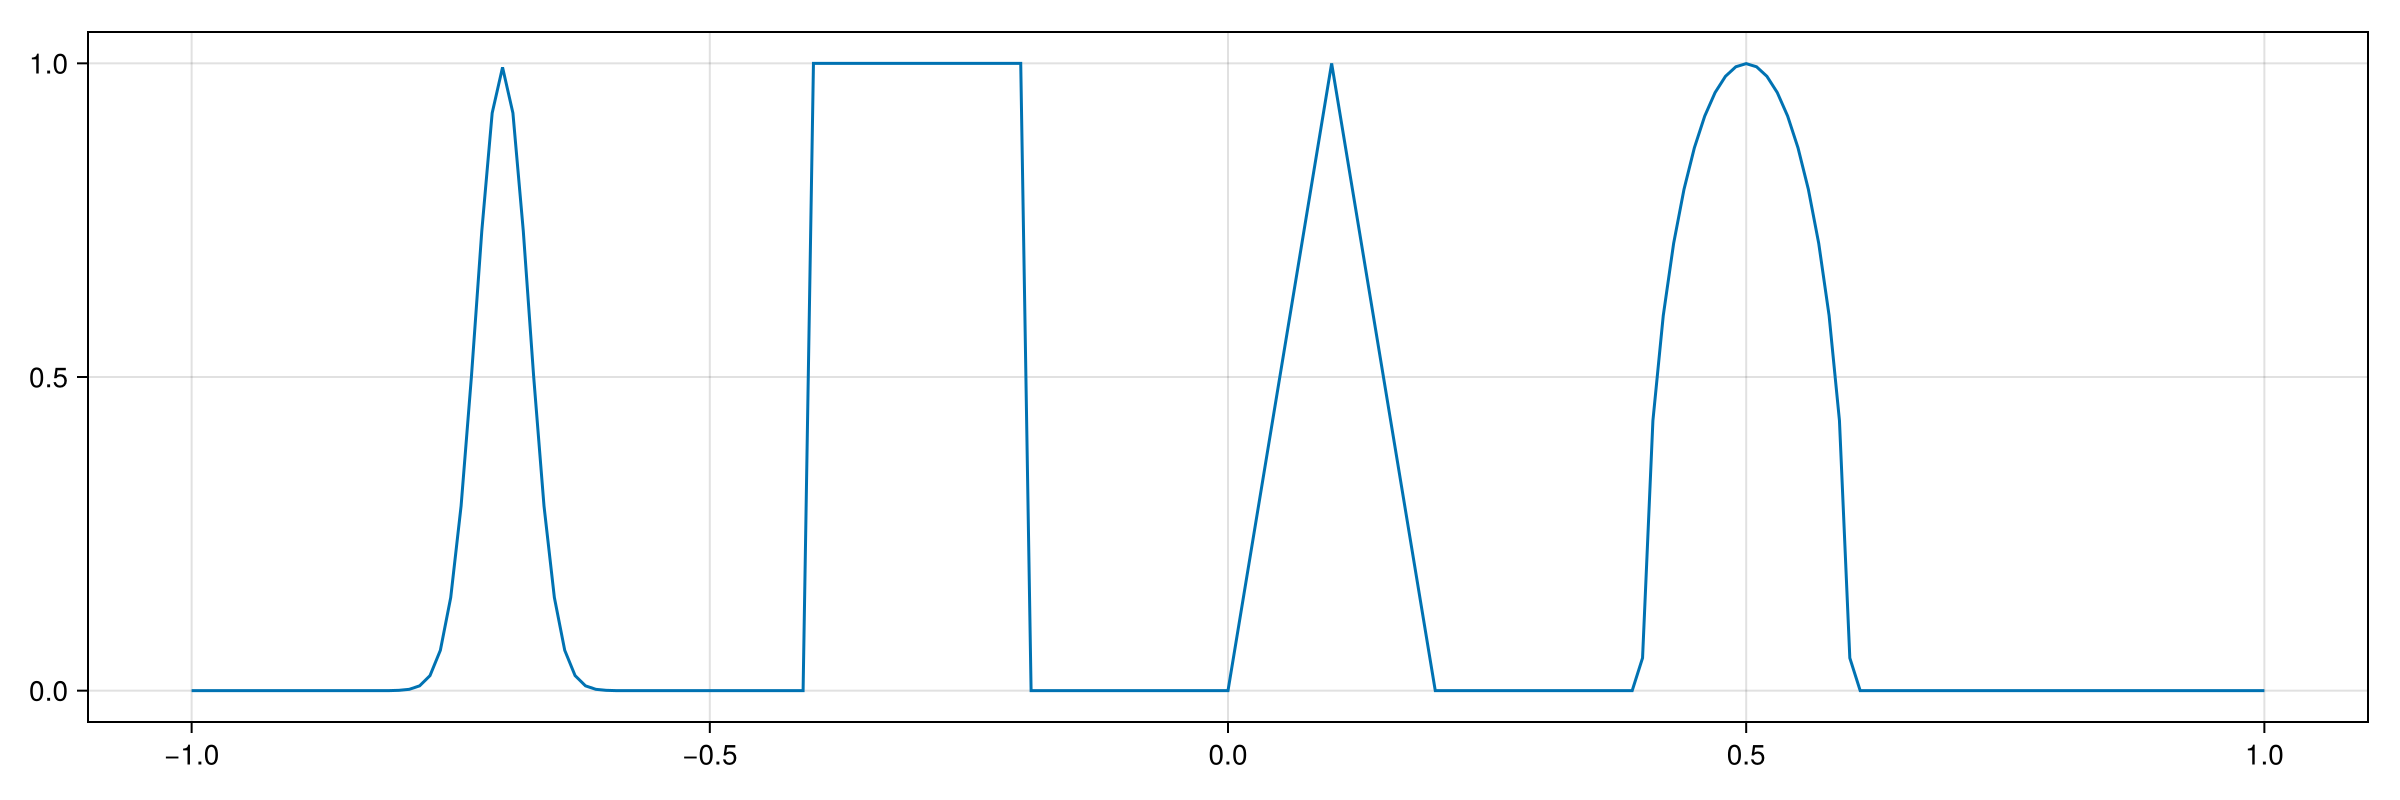

In [47]:
# the initial condition
@inline G(x, β, z) = exp(-β*(x - z)^2)
@inline F(x, α, a) = √(max(1 - α^2*(x-a)^2, 0.0))

const Z = -0.7
const δ = 0.005
const β = log(2)/(36*δ^2)
const a = 0.5
const α = 10

@inline function cᵢ(x)
    if x <= -0.6 && x >= -0.8
        return 1/6*(G(x, β, Z-δ) + 4*G(x, β, Z) + G(x, β, Z+δ))
    elseif x <= -0.2 && x >= -0.4
        return 1.0
    elseif x <= 0.2 && x >= 0.0
        return 1.0 - abs(10 * (x - 0.1))
    elseif x <= 0.6 && x >= 0.4
        return 1/6*(F(x, α, a-δ) + 4*F(x, α, a) + F(x, α, a+δ))
    else
        return 0.0
    end
end

fig = Figure(size = (1200, 400))
ax  = Axis(fig[1, 1])
lines!(ax, -1:0.01:1, map(cᵢ, -1:0.01:1))
display(fig);

Let's build a function that will allow us to investigate different methods. 
We use a Periodic domain, so that, with a velocity `u = 1` the wave should return in the same position at time `t = 2n` and integer `n`

In [68]:
function advect_tracer(advection; timestepper=:RungeKutta3, closure=nothing, Nx=128, stop_time=2)
    grid = RectilinearGrid(size=Nx, x=(-1, 1), halo=6, topology=(Periodic, Flat, Flat))

    model = NonhydrostaticModel(; timestepper, grid, closure, advection, tracers = :c)

    set!(model, u=1, c=cᵢ)
    simulation = Simulation(model; Δt=0.7/Nx, stop_time)
    run!(simulation)
    return model.tracers.c
end

advect_tracer (generic function with 1 method)

We try different advection schemes and plot their result with the initial condition. 
<br>
**NOTE!** the solutions should all overlap

[ Info: testing advection Centered
[ Info: testing advection Upwind order 3
[ Info: testing advection Upwind order 9
[ Info: testing advection WENO order 3
[ Info: testing advection WENO order 9


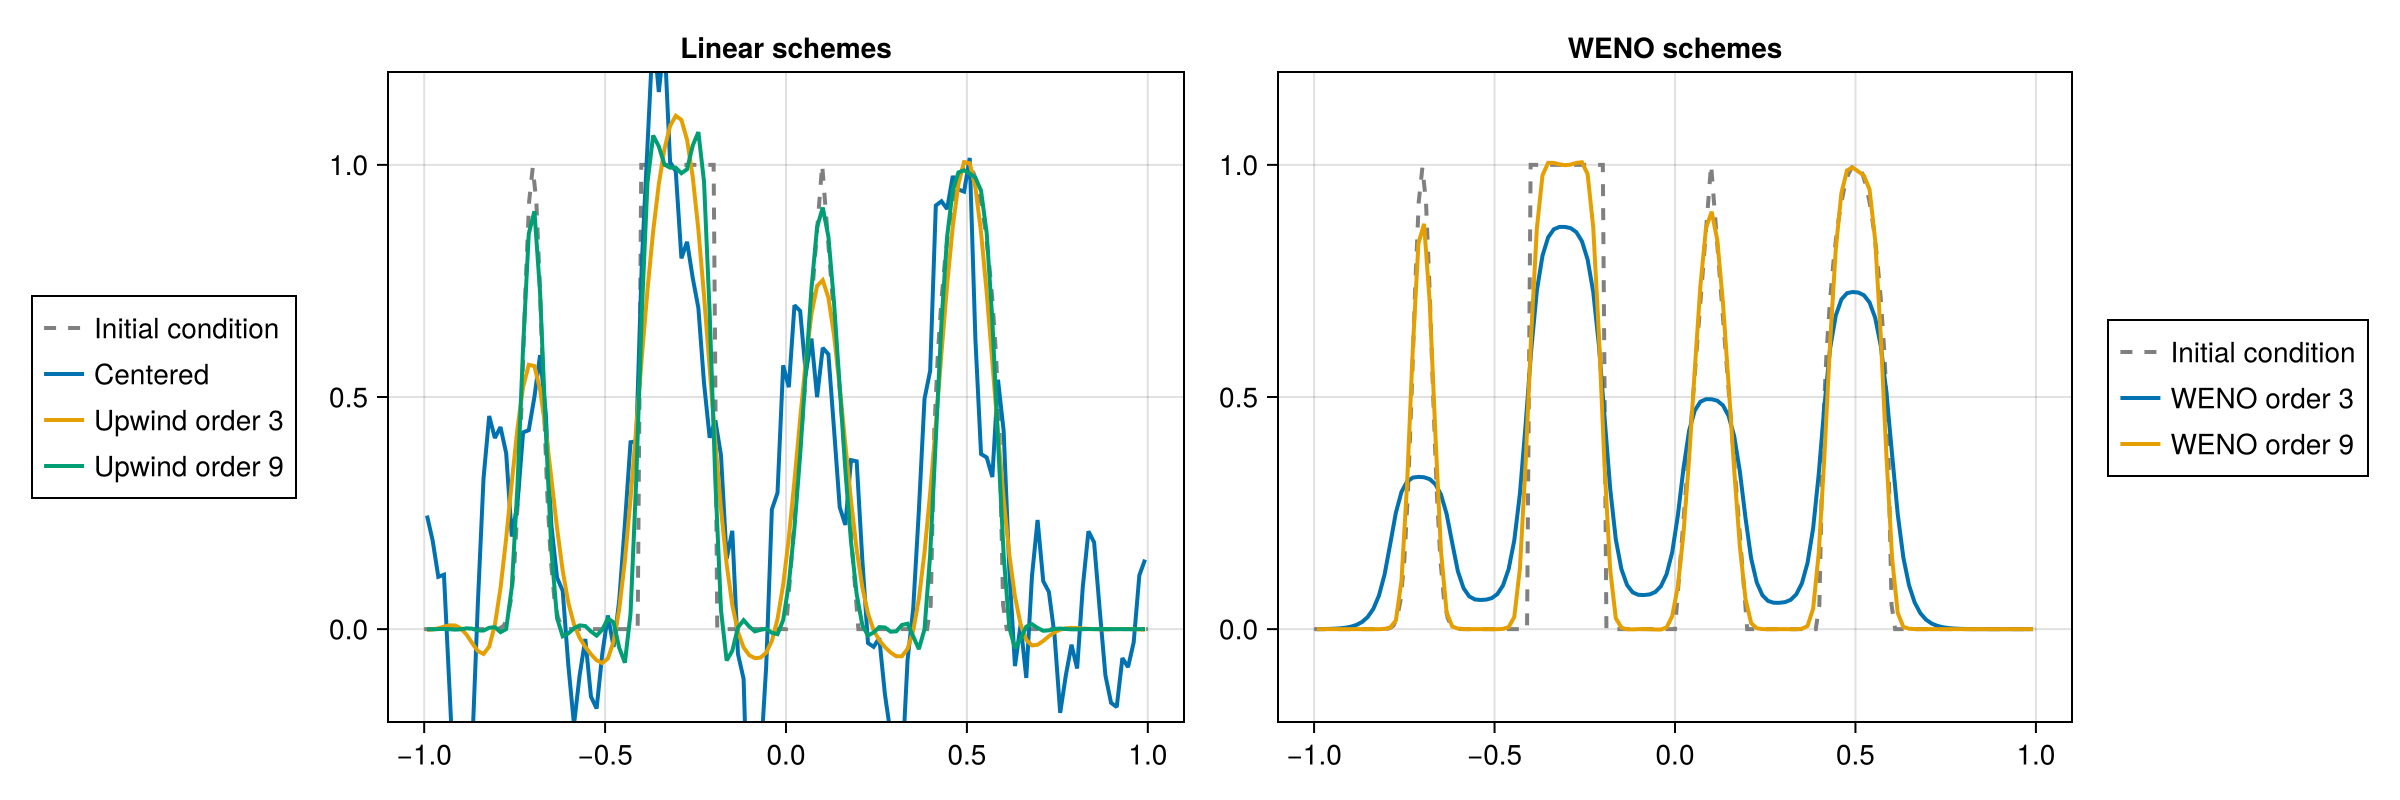

In [69]:
fig = Figure(size = (1200, 400))
axl = Axis(fig[1, 1], title="Linear schemes")
axn = Axis(fig[1, 2], title="WENO schemes")
lines!(axl, -1:0.01:1, map(cᵢ, -1:0.01:1), label="Initial condition", linewidth=2, linestyle=:dash, color=:grey)
lines!(axn, -1:0.01:1, map(cᵢ, -1:0.01:1), label="Initial condition", linewidth=2, linestyle=:dash, color=:grey)

linear_schemes = [Centered(), UpwindBiased(order=3), UpwindBiased(order=9)]
nonlinear_schemes = [WENO(order=3), WENO(order=9)]
linear_names = ["Centered", "Upwind order 3", "Upwind order 9"]
nonlinear_names = ["WENO order 3", "WENO order 9"]

for (advection, name) in zip(linear_schemes, linear_names)
    @info "testing advection $name"
    c = @suppress advect_tracer(advection)
    lines!(axl, c, label=name, linewidth=2)
end
for (advection, name) in zip(nonlinear_schemes, nonlinear_names)
    @info "testing advection $name"
    c = @suppress advect_tracer(advection)
    lines!(axn, c, label=name, linewidth=2)
end
ylims!(axl, -0.2, 1.2)
ylims!(axn, -0.2, 1.2)
Legend(fig[1, 0], axl)
Legend(fig[1, 3], axn)

display(fig);

What is the advection scheme of our ocean model?

In [70]:
ocean.model

HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── grid: 360×180×50 ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 7×7×4 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── tracers: (T, S, e)
├── closure: CATKEVerticalDiffusivity{VerticallyImplicitTimeDiscretization}
├── buoyancy: SeawaterBuoyancy with g=9.80665 and BoussinesqEquationOfState{Float64} with ĝ = NegativeZDirection()
├── free surface: SplitExplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── substepping: FixedSubstepNumber(50)
├── advection scheme: 
│   ├── momentum: Vector Invariant, Dimension-by-dimension reconstruction
│   ├── T: FluxFormAdvection(x=WENO(order=7), y=WENO(order=7), z=Centered(order=2))
│   ├── S: FluxFormAdvection(x=WENO(order=7), y=WENO(order=7), z=Centered(order=2))
│   └── e: Nothing
└── coriolis: HydrostaticSphericalCoriolis{Oceananigans.Coriolis.ActiveCellEnstrophyConserving, Float64